In [ ]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import fdrcorrection

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter

from imblearn.over_sampling import SMOTE

import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crawford/gene-expression")

print("Path to dataset files:", path)

100%|██████████| 1.41M/1.41M [00:00<00:00, 99.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/crawford/gene-expression/versions/3


In [ ]:
# Loading training dataset
df_train = pd.read_csv('/root/.cache/kagglehub/datasets/crawford/gene-expression/versions/3/data_set_ALL_AML_train.csv')

# Loading testing dataset
df_test = pd.read_csv('/root/.cache/kagglehub/datasets/crawford/gene-expression/versions/3/data_set_ALL_AML_independent.csv')

print(df_train.shape)
print(df_test.shape)

(7129, 78)
(7129, 70)


In [ ]:
# Remove call columns in training dataset
columns_to_remove_train = [col for col in df_train if 'call' in col]
train = df_train.drop(columns_to_remove_train, axis=1)

# Remove call columns in testing dataset
columns_to_remove_test = [col for col in df_test if 'call' in col]
test = df_test.drop(columns_to_remove_test, axis=1)

In [ ]:
train.columns

Index(['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '34', '35',
       '36', '37', '38', '28', '29', '30', '31', '32', '33'],
      dtype='object')

In [ ]:
# Transpose row and columns in training set
X_train = train.T

# Transpose row and columns in testing set
X_test = test.T

In [ ]:
# Set the second row (Gene Accession Number) as the column names
X_train.columns = X_train.iloc[1]  # for training set
X_test.columns = X_test.iloc[1]  # for testing set

# Drop the first two rows (Gene Description and Gene Accession Number) and reindex
X_train = X_train.iloc[2:].reset_index(drop=True)  # for training set
X_test = X_test.iloc[2:].reset_index(drop=True)  # for testing set

print(X_train.shape)
print(X_test.shape)

(38, 7129)
(34, 7129)


In [ ]:
# Convert data values to numeric for training set
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Convert data values to numeric for testing set
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Load labels
labels = pd.read_csv('/root/.cache/kagglehub/datasets/crawford/gene-expression/versions/3/actual.csv')

print(labels.shape)
labels.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [ ]:
# Merge all dataset
merged_X = pd.concat([X_train, X_test], ignore_index=True, axis=0)
merged_XY = pd.concat([merged_X, labels], axis=1)

print(merged_XY.shape)
merged_XY.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,ALL
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,ALL
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,ALL
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,ALL
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,ALL


In [ ]:
# Check for nulls
null_counts = merged_XY.isnull().sum().max()

print('Columns with Null Values:')
print(null_counts)

Columns with Null Values:
0


In [ ]:
# Check for label imbalance
merged_XY['cancer'].value_counts()

,count
cancer,
ALL,47
AML,25


In [ ]:
# Replace values in the 'cancer' column with 0 for 'ALL' and 1 for 'AML'
cancer_mapping = {'ALL': 0, 'AML': 1}
merged_XY['cancer'] = merged_XY['cancer'].map(cancer_mapping)

In [ ]:
print(merged_XY.shape)
merged_XY.head()

(72, 7131)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,patient,cancer
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,-125,389,-37,793,329,36,191,-37,1,0
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,-36,442,-17,782,295,11,76,-14,2,0
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,33,168,52,1138,777,41,228,-41,3,0
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,218,174,-110,627,170,-50,126,-91,4,0
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,57,504,-26,250,314,14,56,-25,5,0


In [ ]:
# Exclude patient and cancer columns
gene_columns = merged_XY.columns.drop(['patient', 'cancer'])
merged_X = merged_X[gene_columns]

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data (calculate mean and standard deviation)
scaler.fit(merged_X)

# Transform the data using the fitted scaler
normalized_merged_X = scaler.transform(merged_X)

# Convert back to pandas DataFrame
normalized_merged_X = pd.DataFrame(normalized_merged_X, columns=gene_columns)

# Concatenate the normalized gene expression data with the patient and cancer columns
normalized_merged_XY = pd.concat([normalized_merged_X, merged_XY[['patient', 'cancer']]], axis=1)

In [ ]:
# Create separate normalized DataFrames for ALL and AML patients
normalized_merged_XY_ALL = normalized_merged_XY[normalized_merged_XY['cancer'] == 0]
normalized_merged_XY_AML = normalized_merged_XY[normalized_merged_XY['cancer'] == 1]

print(normalized_merged_XY_ALL.shape)
print(normalized_merged_XY_AML.shape)

(47, 7131)
(25, 7131)


In [ ]:
# Drop 'patient' and 'cancer' columns for each normalized_merged_XY_ALL and normalized_merged_XY_AML
normalized_merged_X_ALL = normalized_merged_XY_ALL.drop(['patient', 'cancer'], axis=1)
normalized_merged_X_AML = normalized_merged_XY_AML.drop(['patient', 'cancer'], axis=1)

In [ ]:
# Perform t-test for each gene
results = []
for gene in normalized_merged_X_ALL.columns:
    t_value, p_value = ttest_ind(normalized_merged_X_ALL[gene], normalized_merged_X_AML[gene], equal_var=False)
    results.append((gene, t_value, p_value))

# Convert results list to DataFrame
df_results = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# Adjust p-values for multiple testing using False Discovery Rate (FDR) correction
rejected, adjusted_p_values = fdrcorrection(df_results['P_Value'])

In [ ]:
df_results.head()

,Gene Accession Number,T_Value,P_Value
0,AFFX-BioB-5_at,-1.025408,0.309136
1,AFFX-BioB-M_at,-1.379648,0.172679
2,AFFX-BioB-3_at,-1.011032,0.315506
3,AFFX-BioC-5_at,-2.422568,0.018676
4,AFFX-BioC-3_at,0.029392,0.976665


In [ ]:
# Set the threshold for significance level
threshold = 0.05

# Get the list of significant genes based on the threshold
significant_genes = df_results[rejected & (adjusted_p_values < threshold)]

# Sort significant genes based on p-values
significant_genes = significant_genes.sort_values(by='P_Value')

# Add rank to significant genes DataFrame
significant_genes['Rank'] = significant_genes['P_Value'].rank()

# Display the results
print("Total Genes: 7129")
print("Significant Genes (T-test):", len(significant_genes))

Total Genes: 7129
Significant Genes (T-test): 34


In [ ]:
# Function to calculate Cohen's d
def cohen_d(x, y):
    """Calculate Cohen's d for two independent samples."""
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    mean_diff = np.mean(x) - np.mean(y)
    s = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / dof)
    return mean_diff / s

# Add Cohen's d calculation to results DataFrame
cohen_d_results = []
for gene in normalized_merged_X_ALL.columns:
    d = cohen_d(normalized_merged_X_ALL[gene], normalized_merged_X_AML[gene])
    cohen_d_results.append(d)

# Add Cohen's d to df_results
df_results['Cohen_D'] = cohen_d_results

# Display results
print(df_results[['Gene Accession Number', 'T_Value', 'P_Value', 'Cohen_D']].head())

  Gene Accession Number   T_Value   P_Value   Cohen_D
0        AFFX-BioB-5_at -1.025408  0.309136 -0.232138
1        AFFX-BioB-M_at -1.379648  0.172679 -0.313732
2        AFFX-BioB-3_at -1.011032  0.315506 -0.213731
3        AFFX-BioC-5_at -2.422568  0.018676 -0.572266
4        AFFX-BioC-3_at  0.029392  0.976665  0.007151


In [ ]:
# Convert results list to DataFrame
df_results1 = pd.DataFrame(results, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# Adjust p-values for multiple testing using False Discovery Rate (FDR) correction
rejected, adjusted_p_values = fdrcorrection(df_results1['P_Value'])

# Add adjusted p-values to results DataFrame
df_results1['Adjusted_P_Value'] = adjusted_p_values

# Select significant genes based on adjusted p-value threshold (e.g., 0.05)
significant_genes1 = df_results1[df_results1['Adjusted_P_Value'] < 0.05]

# Print significant genes
print("Significant Genes:")
print(significant_genes)

# --- Add Hypothesis Testing Summary Here ---
# Hypothesis testing summary
for gene in significant_genes['Gene Accession Number']:
    mean_ALL = normalized_merged_X_ALL[gene].mean()
    mean_AML = normalized_merged_X_AML[gene].mean()
    print(f'Hypothesis: The mean expression of {gene} in ALL is different from AML')
    print(f'Mean ALL: {mean_ALL}, Mean AML: {mean_AML}')

Significant Genes:
     Gene Accession Number   T_Value   P_Value  Rank
3300             U49248_at  5.074976  0.000004   1.0
4534             X74262_at  4.800367  0.000009   2.0
5253             D38073_at  4.759275  0.000010   3.0
5351             M69181_at  4.597115  0.000022   4.0
1305             L13278_at  4.549869  0.000022   5.0
4195             X17042_at -4.746617  0.000037   6.0
378              D32050_at  4.357197  0.000045   7.0
531              D63874_at  4.306755  0.000054   8.0
4660             X81372_at  4.294243  0.000057   9.0
2640             U05237_at  4.257756  0.000063  10.0
2241             M80254_at -4.688971  0.000063  11.0
6280           M31211_s_at  4.258540  0.000067  12.0
1927        M31303_rna1_at  4.227150  0.000072  13.0
5417             U47077_at  4.157827  0.000092  14.0
3800             U79734_at -4.239328  0.000100  15.0
2347             M91432_at  4.109578  0.000106  16.0
4327             X59417_at  4.086845  0.000128  17.0
1259             L09717_at 

In [ ]:
significant_genes_Acc = significant_genes['Gene Accession Number']

# Extracting gene expression data
significant_genes_data_all = normalized_merged_XY_ALL[significant_genes_Acc]
significant_genes_data_aml = normalized_merged_XY_AML[significant_genes_Acc]

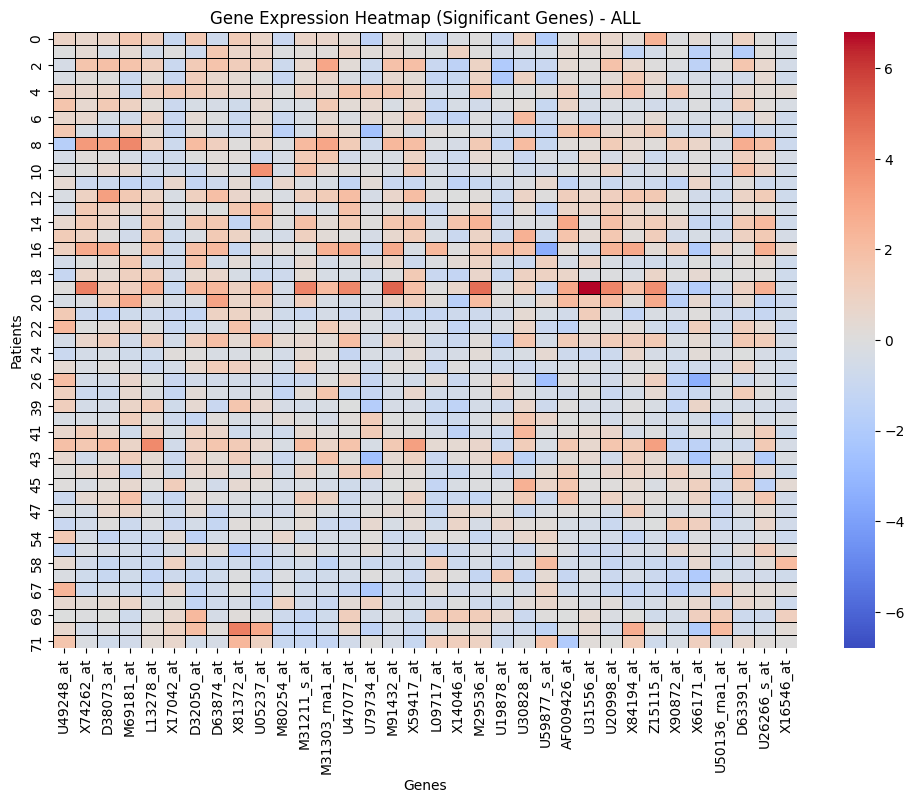

In [ ]:
# For the comparison, use the same maximum absolute expression value for ALL and AML patients
max_abs_value_all = max(abs(significant_genes_data_all.values.max()), abs(significant_genes_data_all.values.min()))

# Generate heatmap for AML patients
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_all, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_abs_value_all, vmax=max_abs_value_all, center=0)
plt.title('Gene Expression Heatmap (Significant Genes) - ALL')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

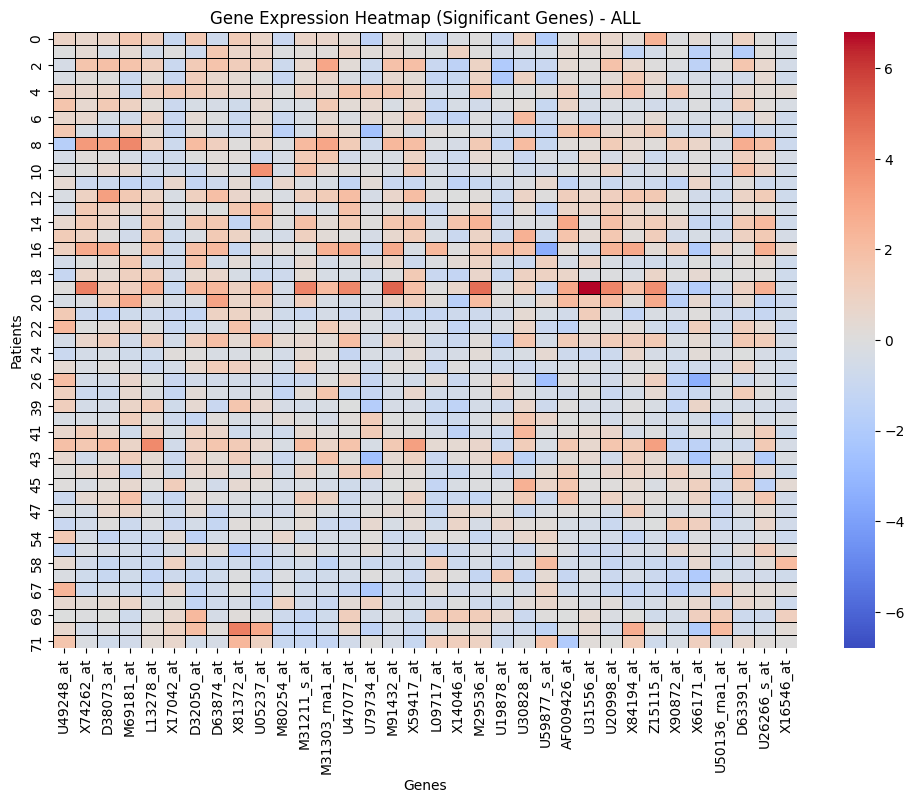

In [ ]:
# For the comparison, use the same maximum absolute expression value for ALL and AML patients
max_abs_value_all = max(abs(significant_genes_data_all.values.max()), abs(significant_genes_data_all.values.min()))

# Generate heatmap for AML patients
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_all, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_abs_value_all, vmax=max_abs_value_all, center=0)
plt.title('Gene Expression Heatmap (Significant Genes) - ALL')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

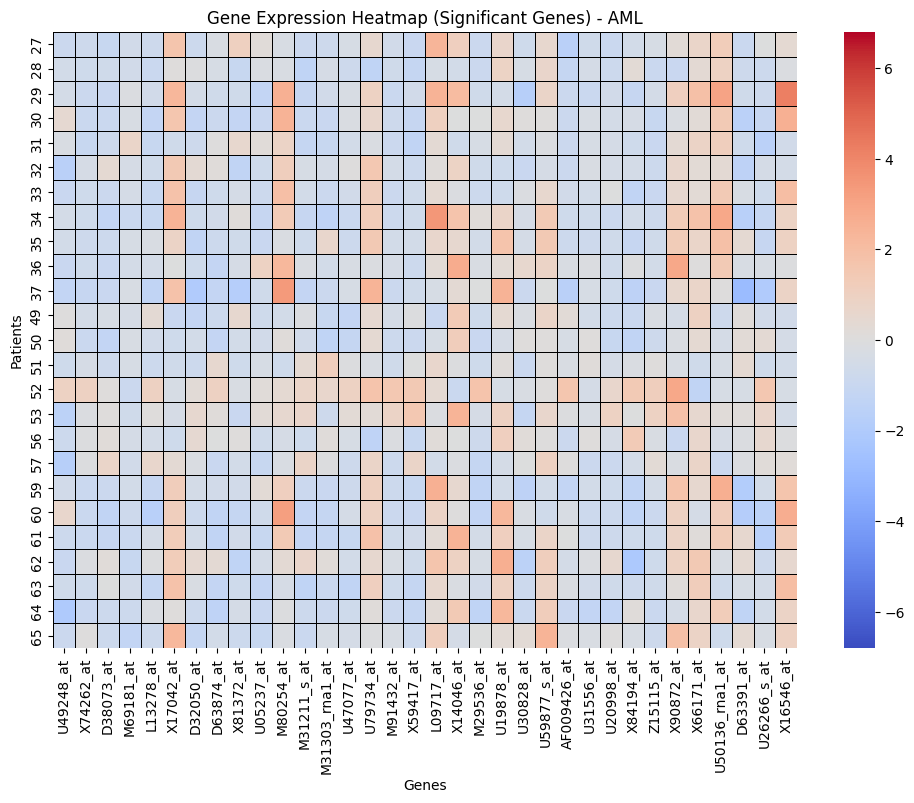

In [ ]:
max_abs_value_aml = max(abs(significant_genes_data_all.values.max()), abs(significant_genes_data_all.values.min()))

# Generate heatmap for AML patients
plt.figure(figsize=(12, 8))
sns.heatmap(significant_genes_data_aml, cmap='coolwarm', linewidths=0.5, linecolor='black', vmin=-max_abs_value_all, vmax=max_abs_value_all, center=0)
plt.title('Gene Expression Heatmap (Significant Genes) - AML')
plt.xlabel('Genes')
plt.ylabel('Patients')
plt.show()

In [ ]:
significant_genes.drop(['T_Value', 'P_Value'], axis=1, inplace=True)
significant_genes.head(3)

,Gene Accession Number,Rank
3300,U49248_at,1.0
4534,X74262_at,2.0
5253,D38073_at,3.0


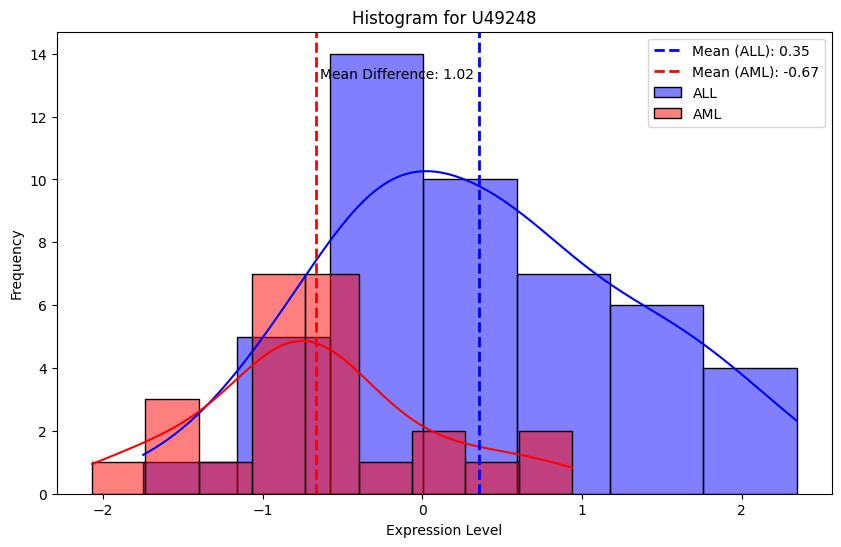

In [ ]:
# Select gene expression data for both cancer types
gene_selected = 'U49248_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

# Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

# Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

# Plot histogram for both cancer types
plt.figure(figsize=(10, 6))

# Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='blue', label='ALL', kde=True)

# Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='red', label='AML', kde=True)

# Annotate mean values
plt.axvline(mean_expression_all, color='blue', linestyle='dashed', linewidth=2, label=f'Mean (ALL): {mean_expression_all:.2f}')
plt.axvline(mean_expression_aml, color='red', linestyle='dashed', linewidth=2, label=f'Mean (AML): {mean_expression_aml:.2f}')

# Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml) / 2, plt.gca().get_ylim()[1]*0.9, f'Mean Difference: {mean_difference:.2f}', ha='center')

# Set labels and title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for U49248')

# Add legend
plt.legend()

# Show plot
plt.show()

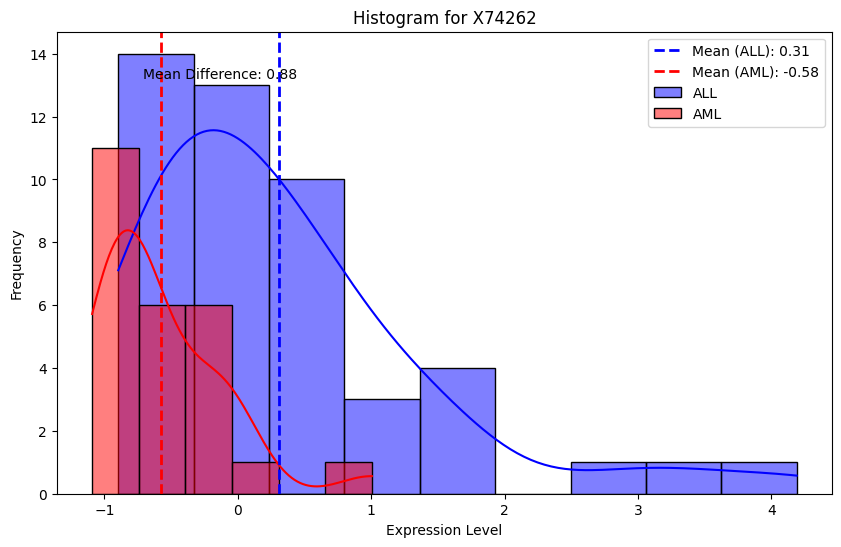

In [ ]:
# Select gene expression data for both cancer types
gene_selected = 'X74262_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

# Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

# Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

# Plot histogram for both cancer types
plt.figure(figsize=(10, 6))

# Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='blue', label='ALL', kde=True)

# Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='red', label='AML', kde=True)

# Annotate mean values
plt.axvline(mean_expression_all, color='blue', linestyle='dashed', linewidth=2, label=f'Mean (ALL): {mean_expression_all:.2f}')
plt.axvline(mean_expression_aml, color='red', linestyle='dashed', linewidth=2, label=f'Mean (AML): {mean_expression_aml:.2f}')

# Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml) / 2, plt.gca().get_ylim()[1]*0.9, f'Mean Difference: {mean_difference:.2f}', ha='center')

# Set labels and title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for X74262')

# Add legend
plt.legend()

# Show plot
plt.show()

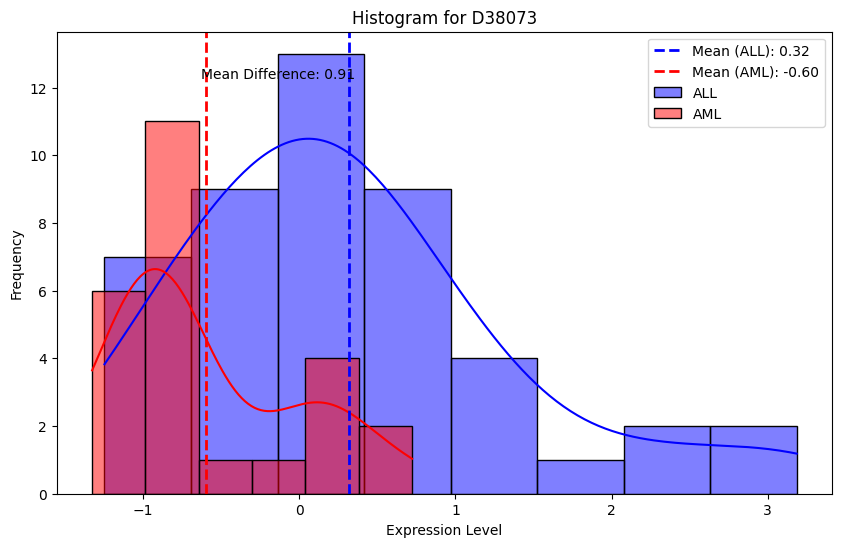

In [ ]:
# Select gene expression data for both cancer types
gene_selected = 'D38073_at'
gene_selected_data_all = normalized_merged_XY_ALL[gene_selected]
gene_selected_data_aml = normalized_merged_XY_AML[gene_selected]

# Calculate mean expression for both cancer types
mean_expression_all = gene_selected_data_all.mean()
mean_expression_aml = gene_selected_data_aml.mean()

# Calculate mean difference
mean_difference = abs(mean_expression_all - mean_expression_aml)

# Plot histogram for both cancer types
plt.figure(figsize=(10, 6))

# Plot histogram for ALL
sns.histplot(gene_selected_data_all, color='blue', label='ALL', kde=True)

# Plot histogram for AML
sns.histplot(gene_selected_data_aml, color='red', label='AML', kde=True)

# Annotate mean values
plt.axvline(mean_expression_all, color='blue', linestyle='dashed', linewidth=2, label=f'Mean (ALL): {mean_expression_all:.2f}')
plt.axvline(mean_expression_aml, color='red', linestyle='dashed', linewidth=2, label=f'Mean (AML): {mean_expression_aml:.2f}')

# Annotate mean difference
plt.text((mean_expression_all + mean_expression_aml) / 2, plt.gca().get_ylim()[1]*0.9, f'Mean Difference: {mean_difference:.2f}', ha='center')

# Set labels and title
plt.xlabel('Expression Level')
plt.ylabel('Frequency')
plt.title('Histogram for D38073')

# Add legend
plt.legend()

# Show plot

In [ ]:
# Select top n genes
top_n_genes = significant_genes.head(3)['Gene Accession Number']

# Select data for the top 50 genes from normalized_merged_XY
top_n_data = normalized_merged_XY[top_n_genes]

print(top_n_data.shape)

(72, 3)


In [ ]:
top_n_data.head()


,U49248_at,X74262_at,D38073_at
0,0.824753,0.596117,0.796240
1,-0.021115,0.361579,-0.294445
2,-0.409757,1.655280,1.867749
3,-0.249728,0.195656,0.043548
4,0.813323,0.593622,0.690767


In [ ]:
# Splitting the data into train and test sets
train_size = 38
normalized_X_train = top_n_data.iloc[:train_size, :]
normalized_X_test = top_n_data.iloc[train_size:, :]

# Check the shapes of the train and test sets
print("Train set shape:", normalized_X_train.shape)
print("Test set shape:", normalized_X_test.shape)

Train set shape: (38, 3)
Test set shape: (34, 3)


In [ ]:
normalized_X_train.head()

,U49248_at,X74262_at,D38073_at
0,0.824753,0.596117,0.796240
1,-0.021115,0.361579,-0.294445
2,-0.409757,1.655280,1.867749
3,-0.249728,0.195656,0.043548
4,0.813323,0.593622,0.690767


In [ ]:
# Split target labels for training and testing
cancer_target = labels.iloc[:,1]
y_train = cancer_target[:38]  # Target labels for training
y_test = cancer_target[38:]  # Target labels for testing

In [ ]:
# Check for labels in train set
y_train.value_counts()

,count
cancer,
ALL,27
AML,11


In [ ]:
# Check for labels in test set
y_test.value_counts()

,count
cancer,
ALL,20
AML,14


In [ ]:
print("Before Upsampling:-")
print(Counter(y_train))

# Use SMOTE to oversample
oversample = SMOTE()
X_train_ov, y_train_ov = oversample.fit_resample(normalized_X_train,y_train)

print("After Upsampling:-")
print(Counter(y_train_ov))

Before Upsampling:-
Counter({'ALL': 27, 'AML': 11})
After Upsampling:-
Counter({'ALL': 27, 'AML': 27})


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseRBM(nn.Module):
    def __init__(self, n_visible, n_hidden, sparsity_target=0.1, sparsity_weight=0.01, k=1):
        super(SparseRBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_visible))
        self.h_bias = nn.Parameter(torch.zeros(n_hidden))
        self.k = k
        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight

    def sample_h(self, v):
        activation = torch.mm(v, self.W.t()) + self.h_bias
        p_h = torch.sigmoid(activation)
        return p_h, torch.bernoulli(p_h)

    def sample_v(self, h):
        activation = torch.mm(h, self.W) + self.v_bias
        p_v = torch.sigmoid(activation)
        return p_v, torch.bernoulli(p_v)

    def forward(self, v):
        h_prob, _ = self.sample_h(v)
        return h_prob

    def free_energy(self, v):
        vbias_term = torch.mv(v, self.v_bias)
        wx_b = torch.mm(v, self.W.t()) + self.h_bias
        hidden_term = torch.sum(F.softplus(wx_b), dim=1)
        return -hidden_term - vbias_term

    def train_step(self, v0, lr=0.01):
        batch_size = v0.size(0)

        # Positive phase
        ph0, h0 = self.sample_h(v0)

        # Negative phase using CD-k
        vk = v0
        for _ in range(self.k):
            _, hk = self.sample_h(vk)
            pvk, vk = self.sample_v(hk)

        # Calculate CD gradients
        positive = torch.mm(v0.t(), ph0)
        negative = torch.mm(vk.t(), self.sample_h(vk)[0])
        grad_W = (positive - negative).t() / batch_size
        grad_v_bias = (v0 - vk).mean(dim=0)
        grad_h_bias = (ph0 - self.sample_h(vk)[0]).mean(dim=0)

        # Calculate sparsity regularization
        h_prob = ph0
        q = h_prob.mean(dim=0)
        eps = 1e-5
        q_clamped = torch.clamp(q, eps, 1 - eps)

        # KL divergence gradient
        d_kl_dq = ((1 - self.sparsity_target) / (1 - q_clamped) -
                  self.sparsity_target / q_clamped)

        # Sparsity gradients
        sparsity_grad_W = torch.mm(v0.t(), h_prob * (1 - h_prob) * d_kl_dq) / batch_size
        sparsity_grad_h_bias = torch.mean(h_prob * (1 - h_prob) * d_kl_dq, dim=0)

        # Apply sparsity weight
        grad_W += self.sparsity_weight * sparsity_grad_W.t()
        grad_h_bias += self.sparsity_weight * sparsity_grad_h_bias

        # Update parameters
        self.W.data += lr * grad_W
        self.v_bias.data += lr * grad_v_bias
        self.h_bias.data += lr * grad_h_bias

        # Reconstruction error
        loss = torch.mean((v0 - vk) ** 2)
        return loss

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Example parameters (adjust based on your dataset)
num_genes = 2000    # Number of features/genes in your dataset
hidden_units = 100   # Number of hidden units in the RBM
batch_size = 32
epochs = 10

# Initialize RBM
rbm = SparseRBM(n_visible=num_genes, n_hidden=hidden_units)

# Example data preparation (replace with your data)
# Your data should be a tensor of shape (num_samples, num_genes)
# Normalized to [0, 1] range (typical for RBMs)
dummy_data = torch.rand(1000, num_genes)  # 1000 samples
dataset = TensorDataset(dummy_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    for batch in data_loader:
        inputs = batch[0]
        loss = rbm.train_step(inputs, lr=0.01)
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(data_loader):.4f}")

# Gene selection (select top 100 genes)
num_selected = 100
gene_importance = torch.sum(torch.abs(rbm.W.data), dim=0)
top_genes = torch.argsort(gene_importance, descending=True)[:num_selected]
print("Selected genes:", top_genes)

Epoch 1/10, Loss: 0.3332
Epoch 2/10, Loss: 0.3329
Epoch 3/10, Loss: 0.3333
Epoch 4/10, Loss: 0.3330
Epoch 5/10, Loss: 0.3329
Epoch 6/10, Loss: 0.3332
Epoch 7/10, Loss: 0.3330
Epoch 8/10, Loss: 0.3328
Epoch 9/10, Loss: 0.3328
Epoch 10/10, Loss: 0.3333
Selected genes: tensor([1189,  275,  417,  760, 1075,  854,  198, 1128,  254,  111, 1817, 1514,
         336,  601,  810,  652, 1739, 1201, 1881, 1054, 1032,  799,  360,  644,
        1066, 1824,   63,  365,  449,  600,    1, 1563,  265, 1920, 1141, 1904,
         907,  505, 1898,  756, 1279, 1974,   41, 1001,  247,   35, 1378,  743,
        1057,    4, 1539,  444,  224,  152,  893,  587, 1031,  941,  965, 1594,
        1465, 1408, 1996, 1458, 1305, 1546, 1785, 1333,  619,  470, 1251, 1729,
         612,  697, 1946, 1915, 1663, 1767, 1384, 1839,  843, 1905,  136,  395,
         534, 1681, 1690, 1991,  661,  235, 1175, 1527,  477, 1630,  400, 1530,
        1752,  725,  311, 1799])


In [ ]:
# Get feature importance from weights
gene_importance = torch.sum(torch.abs(rbm.W.data), dim=0)
top_genes = torch.argsort(gene_importance, descending=True)[:num_selected]

Top Genes and Their Importance Scores:
Gene 1189: Importance = 1.2315
Gene 275: Importance = 1.1220
Gene 417: Importance = 1.1204
Gene 760: Importance = 1.1187
Gene 1075: Importance = 1.1011
Gene 854: Importance = 1.0983
Gene 198: Importance = 1.0951
Gene 1128: Importance = 1.0945
Gene 254: Importance = 1.0814
Gene 111: Importance = 1.0811
Gene 1817: Importance = 1.0690
Gene 1514: Importance = 1.0689
Gene 336: Importance = 1.0675
Gene 601: Importance = 1.0607
Gene 810: Importance = 1.0519
Gene 652: Importance = 1.0505
Gene 1739: Importance = 1.0500
Gene 1201: Importance = 1.0498
Gene 1881: Importance = 1.0495
Gene 1054: Importance = 1.0473
Gene 1032: Importance = 1.0440
Gene 799: Importance = 1.0437
Gene 360: Importance = 1.0402
Gene 644: Importance = 1.0355
Gene 1066: Importance = 1.0348
Gene 1824: Importance = 1.0334
Gene 63: Importance = 1.0332
Gene 365: Importance = 1.0316
Gene 449: Importance = 1.0284
Gene 600: Importance = 1.0218
Gene 1: Importance = 1.0211
Gene 1563: Importance 

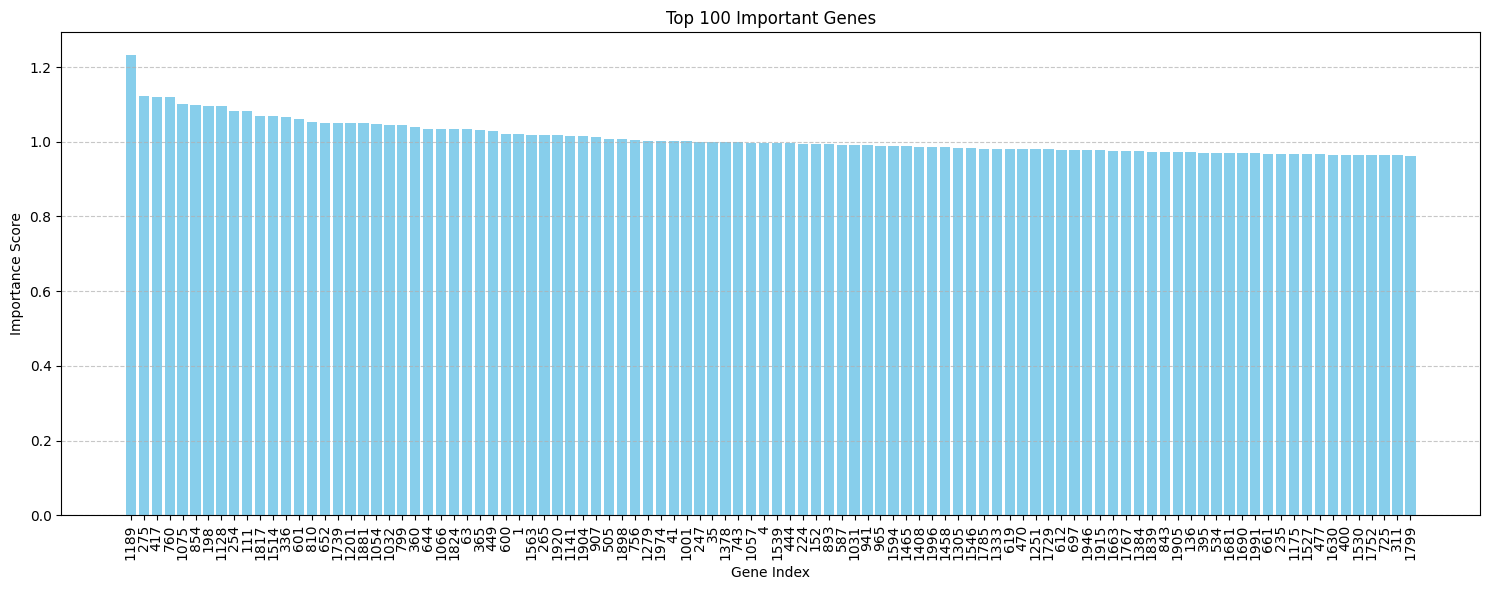

In [ ]:
# After training and gene selection
import matplotlib.pyplot as plt

# Get feature importance and top genes
num_selected = 100  # Number of genes to select
gene_importance = torch.sum(torch.abs(rbm.W.data), dim=0).cpu().numpy()
top_genes = torch.argsort(torch.tensor(gene_importance), descending=True)[:num_selected].cpu().numpy()

# Print top genes with their importance scores
print("Top Genes and Their Importance Scores:")
for i, gene_idx in enumerate(top_genes):
    print(f"Gene {gene_idx}: Importance = {gene_importance[gene_idx]:.4f}")

# Plot feature importance
plt.figure(figsize=(15, 6))
plt.bar(range(num_selected), gene_importance[top_genes], color='skyblue')
plt.title(f'Top {num_selected} Important Genes')
plt.xlabel('Gene Index')
plt.ylabel('Importance Score')
plt.xticks(range(num_selected), top_genes, rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()